<a href="https://colab.research.google.com/github/cstrachan342/Notebook-Library-/blob/notebooks/microscopic_fungi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification Using Feature Extraction & Bayesian Optimization**

The goal of this project was to experiment with the use of feature extraction to build a model with high accuracy using a challenging dataset. I wanted to  see if Bayesian Optimization could then further improve my model. I planned to showcase other techniques rather than the traditional methods such as transfer learning, which is the typical approach to a project like this. By documenting my thought process I intend to show a deep understanding for computer vision tasks.

The dataset I will be using is DeFungi, which is a set of images taken directly from a mycological examination of microscopic fungi. There are 5 classes of fungi: Arthroconidia, Beaded Arthroconidial Septate Hyaline Hyphae, Brown Beaded Hyphae, Septate Hyaline Hyphae with Chlamydioconidia and Tortuous Septate Hyaline Hyphae. This database can be found at https://www.kaggle.com/datasets/joebeachcapital/defungi.

I will start by installing and importing all the modules I need.


In [ ]:
!pip install scikit-optimize

In [ ]:
import os
import cv2
import numpy as np
import albumentations as a
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras.applications.vgg16 import VGG16
import xgboost as xgb
from timeit import default_timer as timer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

### **Dataset Analysis**

I will plot the number of images in each class to see the extent of the dataset imbalance. By counting the number of images in each directory I can create a dictionary and store the results, ready to plot a bar graph.



In [ ]:
value_counts = {}
for i in os.listdir('/content/drive/MyDrive/microscopic_fungi/dataset'):
  if i != '.ipynb_checkpoints':
    num = len(os.listdir(f'/content/drive/MyDrive/microscopic_fungi/dataset/{i}'))
    value_counts[i] = num

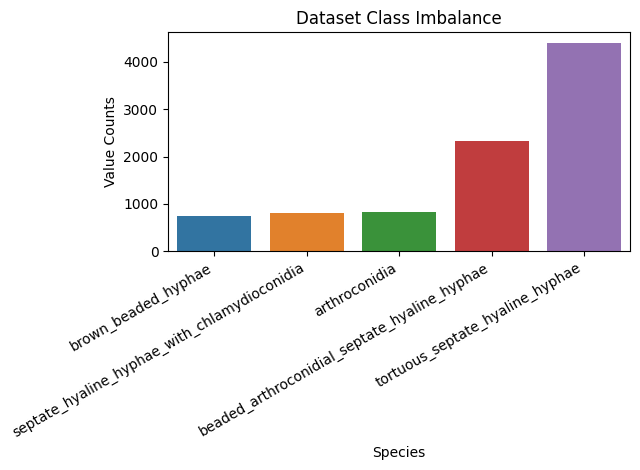

In [ ]:
keys = list(value_counts.keys())
values = list(value_counts.values())

ax = sns.barplot(
    x= keys,
    y= values
)

plt.xlabel('Species')
plt.ylabel('Value Counts')
plt.title('Dataset Class Imbalance')

plt.xticks(rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

While the dataset is not perfect, it is still useable to train a successful model. The underrepresented classes have high enough prevalence for the model to learn their features and be capable of predicting their classes correctly. To start I will train a model using feature extraction and see how the effectively it can learn before augmenting the dataset or optimizing the model.

I will start by defining a function to loop through a target directory and store all the image paths in a list.

In [ ]:
def image_paths_list(target_dir: str):

  paths = []

  for dirpath, dirnames, filenames in os.walk(target_dir):
      for files in filenames:
        paths.append(str(dirpath) + '/' +  str(files))

  return paths

By using this function on my dataset directory I will obtain a list of images which I will loop though, opening the images and resizing to `(224,224)` then storing in `data_images`, ready for feature extraction. I resize to `(224,224)` to match the input size required by VGG16. Additionally, I will obtain the class name by extracting it from each image path and storing in `data_labels`.

I like to add `try:` and `except:` clauses when iterating through files in case issues out of my control happen. By doing so I can investigate and fix issues afterwards without losing the progress made in previous iterations.


In [ ]:
data_images = []
data_labels = []

for directory_path in image_paths_list('/content/drive/MyDrive/microscopic_fungi/dataset'):
  try:
    class_id = os.path.dirname(directory_path).rpartition('/')[-1]

    img = cv2.imread(directory_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))

    data_images.append(img)
    data_labels.append(class_id)

  except:
    print('Error with ', directory_path)

Now I can process my labels into values between 0 and the number of classes minus 1. By using `LabelEncoder()` this will do it automatically for me. It also allows me to inverse the labels back to there original values when evaluating performance later.

In [ ]:
process = preprocessing.LabelEncoder()

process.fit(data_labels)
data_labels_encoded = process.transform(data_labels)

I will then convert my lists into numpy arrays before splitting into train and test sets using `sklearn.train_test_split()`. Following that I will normalize my dataset by dividing my X values by `255.0`.

In [ ]:
data_images = np.array(data_images)
data_labels = np.array(data_labels)

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_images, data_labels_encoded, test_size=0.2, shuffle=True)

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

### **VGG16 Feature Extraction**

I will be using VGG16 as a feature extractor. By removing the last fully connected layer at the end of the network I am able to extract intricate visual features from images.

To do this I will use a pretrained VGG16 model from Keras and set `include_top` to False and freeze all layers. Subsequently, I can predict `X_train` and store the output. As the last layer has been removed the output will be a numpy array of features rather than an prediction of a class. To prepare my data for XGBoost I will then reshape the features into a 1D array.

In [ ]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in VGG_model.layers:
	layer.trainable = False

In [ ]:
features = VGG_model.predict(X_train, batch_size=4)

In [ ]:
features = features.reshape(features.shape[0], -1)

Now all my data is pre-processed I can fit my XGBoost Classifier. I will not set any hyperparameters yet, I will just see how well the classifier is able to fit the data.

In [ ]:
model = xgb.XGBClassifier()

model.fit(features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Now the model is fit I can evaluate its performance on my test set. By following the same process as before I can predict `X_test` using the same VGG16 model then flatten output to 1D arrays.

After that I can use my XGBoost Classifier to predict the output classes on the flattened arrays. By using `accuracy_score` I can gain a rough idea how my model is performing.

In [ ]:
test_features = VGG_model.predict(X_test)
test_features = test_features.reshape(test_features.shape[0], -1)

57/57 [==============================] - 18s 157ms/step


In [ ]:
 prediction = model.predict(test_features)

In [ ]:
print("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.693911135490949


Initially the model seems to be performing well with an accuracy of 69%. Now I will use a Confusion Matrix to analyse the results and gain a deeper insight.

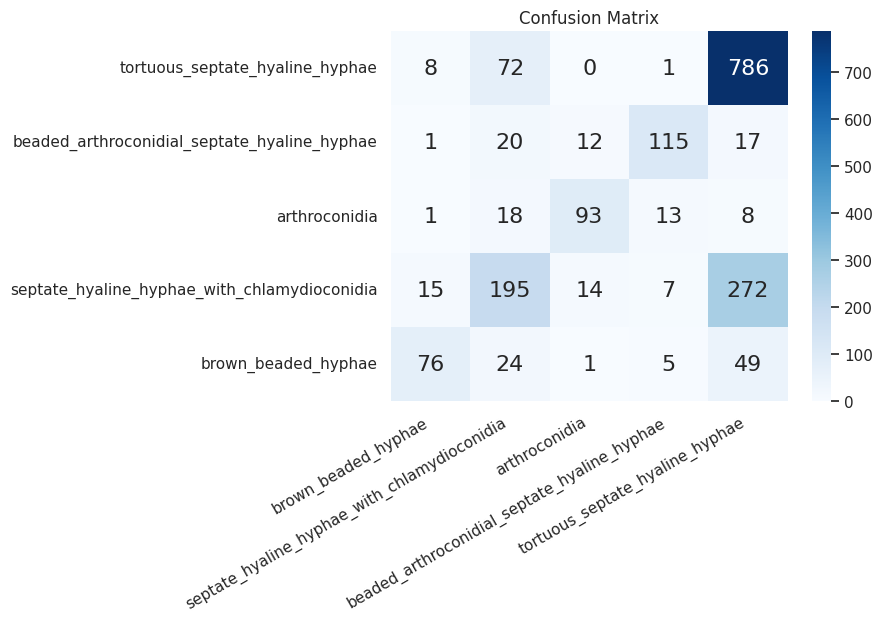

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, prediction), keys, keys)

sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=30, horizontalalignment='right')
ax.invert_yaxis()

plt.show()

The model trains successfully to a limited degree. It is able to learn some features from each class, classifying the majority of classes correct as shown by accuracy being 69%. One of the largest errors it shows is classifying Tortuous Septate Hyaline Hyphae as Septate Hyaline Hyphae with Chlamydioconidia with an overwhelming 272 classes labelled incorrectly as shown on the confusion matrix.

With the help of augmentation and oversampling to increase representation of certain classes the accuracy will improve in later models.

### **Image Augmentation & Oversampling**

To help deal with the imbalanced dataset I will oversamle and augment the data to increase representation of certain classes within the dataset. I will do this by using Albumentations module. Albumentations has a wide range of diverse augmentations that are optimized for fast and efficient execution. I will use the following:

1.   Colour Jitter
2.   Zoom + Blur
3.   Brightness + Contrast Change
4.   Horizontal + Vertical Flip
5.   Perspective Change

All of these augmentations are set at different probabilities so that they do not all run simultaneously. This means the images get a wide range of augmentations and the dataset is not filled up with duplicated images. By following this method it allows for the network to learn the underlying patterns and textures of the underrepresented classes rather than memorising noise and specific patterns.

In [ ]:
aug_transform = a.Compose([a.ColorJitter(p=0.25),
                           a.ZoomBlur(p=0.15),
                           a.RandomBrightnessContrast(p=0.25),
                           a.HorizontalFlip(p=0.5),
                           a.VerticalFlip(p=0.5),
                           a.Perspective(p=0.5),
])

I have specified what classes I want to be augmented in `class_to_aug`.
Then by iterating through the training dataset, when one of those classes appears it will augment the image and append to the end of the numpy array `X_train`, while also appending the class to the end of `y_train` as to ensure both arrays match. This enables me to oversample the underrepresented classes to make up for the class imbalance.

In [ ]:
# i must un-normalize the data so it is all in the same format. i will normalize again later in the code when i have the oversampled dataset
X_train = X_train * 255.0

In [ ]:
class_to_aug = ['brown_beaded_hyphae', 'septate_hyaline_hyphae_with_chlamydioconidia', 'arthroconidia']

for v, i in enumerate(y_train):
  try:
    if i in class_to_aug:
      image = cv2.convertScaleAbs(X_train[v])
      image = aug_transform(image= image)

      image = image['image'].reshape(1, 224, 224, 3)
      label = i.reshape(1)

      X_train = np.concatenate((X_train, image), axis=0)
      y_train = np.concatenate((y_train, label), axis=0)

  except:
    print('Error with', v)

The class 'Tortuous Septate Hyaline Hyphae' will still be over represented however the other 4 classes more are even now. Potentially you could under sample 'Tortuous Septate Hyaline Hyphae' class however I do not typically like to under sample. I find it loses valuable information needed for training leading to poor generalization and performance. There are situations where I do find undersampling to be beneficial, but this is not one of them.

Now I will follow the same process as before, using the same VGG16 model defined earlier to extract features then flatten to a 1D array.

In [ ]:
# normalize data altogether, X_test is already normalized from earlier so we can leave that
X_train = X_train / 255.0

In [ ]:
# X_train now has base dataset with additional augmented images
aug_features = VGG_model.predict(X_train, batch_size=4)

aug_features = aug_features.reshape(aug_features.shape[0], -1)

2295/2295 [==============================] - 64s 25ms/step


Now I have my augmented features and I am ready to fit a new XGBoost Classifier.

In [ ]:
aug_model = xgb.XGBClassifier()

aug_model.fit(aug_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

I will use the same test set as earlier to see if augmentation and oversampling has improved my model. No changes need to be made as I want to evaluate on the exact same data to measure the effect of oversampling and data augmentation.

In [ ]:
test_features = VGG_model.predict(X_test)
test_features = test_features.reshape(test_features.shape[0], -1)

prediction = aug_model.predict(test_features)

57/57 [==============================] - 13s 171ms/step


In [ ]:
print("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.7092704333516182


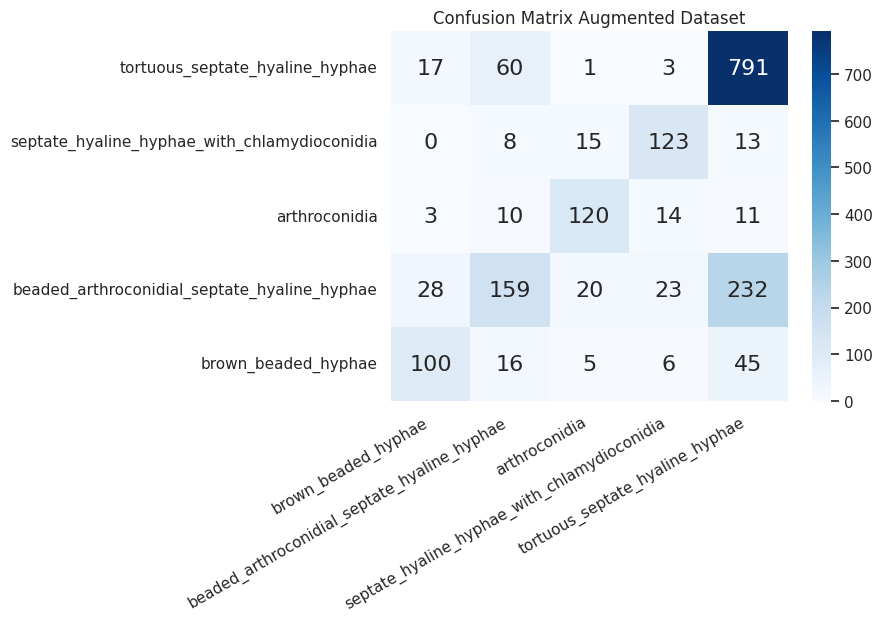

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, prediction), keys, keys)

sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix Augmented Dataset')
plt.xticks(rotation=30, horizontalalignment='right')
ax.invert_yaxis()

plt.show()

From seeing the accuracy and the confusion matrix above I can tell my new model trained on augmented data, is the better of the two models. Not only does it score higher in accuracy but it is also improved in areas such as the miss-classification of Tortuous Septate Hyaline Hyphae as Septate Hyaline Hyphae with Chlamydioconidia. By augmenting the dataset it now shows only 232 were incorrectly predicted opposed to a previous 272. Still not perfect, but the augmentations has improved overall accuracy.

### **Bayesian Optimization**

By using Bayes Optimization I will further improve the accuracy of my model. This method is typically more efficiently than traditional methods like grid search or random search however is computationally expensive and is very time consuming.

The very basic concept is a prior distribution is established to give initial beliefs about hyperparameters performance. The algorithm iteratively updates the prior distribution using new observed data to compute a posterior distribution. Throughout this iteration, hyperparameters are adjusted until a set is established that maximise the desired optimization metric. All sets of hyperparameters are stored and best set it returned.

As my previous model performed best with the augmented dataset, I will use that again.

I will be optimising the below search space:

*   `learning_rate` -  The step size at each iteration while moving towards minimising the loss function.
*   `max_depth` - The maximum depth of a tree.
*   `subsample` - Denotes the ratio of samples to be used for training each tree.
*   `colsample_bytree` - Indicates the subsample ratio of columns when constructing each tree.
*   `reg_lambda` - L2 regularization term on weights.
*   `n_estimators` - Represents the number of boosting rounds or trees to build.
*   `gamma` - Specifies the minimum loss reduction required to make a split on a node.
*   `min_child_weight` -  Specifies the minimum sum of instance weight needed in a child.




In [ ]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(8, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'),
                 'reg_lambda': Real(1e-9, 1000., 'uniform'),
                 'n_estimators': Integer(4000, 8000),
                 'gamma': Real(0.01, 10.0, 'uniform'),
                 'min_child_weight': Integer(8, 140)
}

I'm utilizing Stratified K-Fold cross-validation with five splits which helps ensure a balanced distribution of classes in each fold, optimizing my models training and evaluation.

In [ ]:
skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=0)

# as augmented dataset is already defined as X_train and y_train I do not have to split dataset again
cv_strategy = list(skf.split(X_train, y_train))

The estimator I will be using is an XGBoost Classifier with the tree method set to `'hist'` and device set to `'cuda'`. This is as I want to train on a GPU to maximise the number of iterations possible before the time limit is reached. The metric I will be optimizing is `'accuracy'` as I have been using that to evaluate my models earlier. As it is unlikely to get a large number of iterations in due to the complex dataset I will evaluate two hyperparameters at once by setting `n_points = 2`.

In [ ]:
estimator = xgb.XGBClassifier(tree_method='hist', device='cuda')

In [ ]:
bayes = BayesSearchCV(estimator = estimator,
                      search_spaces = search_spaces,
                      scoring = 'accuracy',
                      cv=cv_strategy,
                      n_iter = 120,
                      n_points = 2,
                      n_jobs = 1,
                      return_train_score = True,
                      refit = False,
                      optimizer_kwargs = {'base_estimator': 'GP'},
                      random_state = 0)

The `DeadlineStopper` is a callback that stops training after a set number of seconds. As I do not have unlimited resources, I have set this to 8 hours.

`DeltaYStopper` stops training after the `n_best` minima are within the `delta` value.

In [ ]:
time_limit = DeadlineStopper(total_time=28800)

convergence_control = DeltaYStopper(delta=0.0001, n_best=5)

Now I have established my search space and estimator, I can fit the model to my data with my two callbacks.

In [ ]:
start_time = timer()

bayes_model = bayes.fit(aug_features, y_train, callback = [time_limit, convergence_control])

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:34:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Total training time: 27084.026 seconds


After training has been completed I will print my best results and hyperparameters to see if Bayesian Optimization has improved my model.

In [ ]:
d=pd.DataFrame(bayes.cv_results_)
best_score = bayes.best_score_
best_score_std = d.iloc[bayes.best_index_].std_test_score
best_params = bayes.best_params_

In [ ]:
print('Best score: ', best_score)
print('Best score std: ', best_score_std)
print('Best hyperparameters: ', best_params)

Best score:  0.7291116606046835
Best score std:  0.007098062097494171
Best hyperparameters:  OrderedDict([('colsample_bytree', 0.1), ('gamma', 0.01), ('learning_rate', 0.01), ('max_depth', 8), ('min_child_weight', 8), ('n_estimators', 4000), ('reg_lambda', 1e-09), ('subsample', 0.5522581748607809)])


As you can see above my model has improved. Now I can fit a new model using the best hyperparameters and evaluate the performance on my test set. While a testing set is not typically necessary when using K folds cross valiation, I opted to maintain my `X_test` from earlier, as I wanted an independant evaluation at the end to measure the improvement Bayesian Optimization offers.

In [ ]:
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(aug_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# i can use test_features which have already been converted into a 1D array earlier
prediction = final_model.predict(test_features)

print("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.7372462973121229


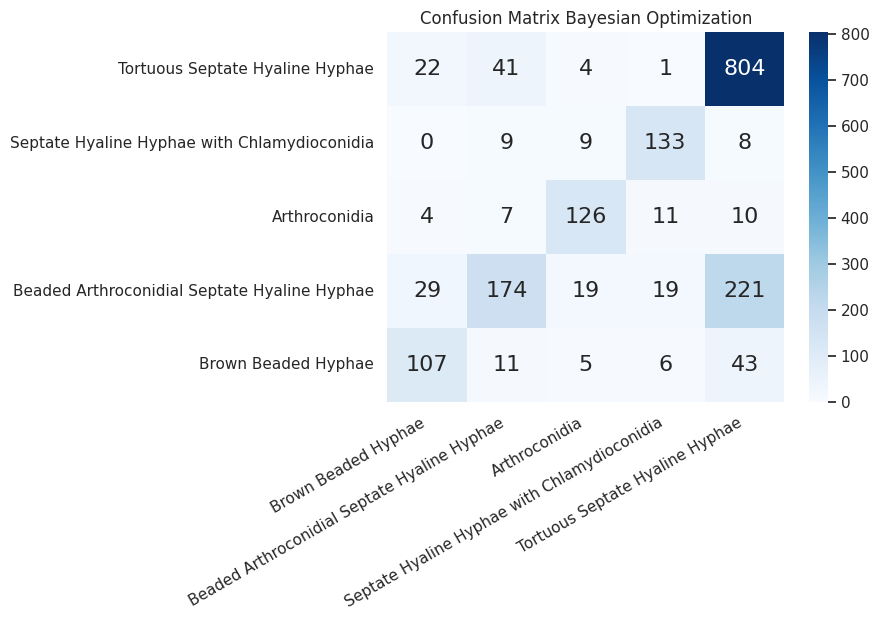

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, prediction), keys, keys)

sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix Bayesian Optimization')
plt.xticks(rotation=30, horizontalalignment='right')
ax.invert_yaxis()

plt.show()

By using Bayesian Optmization I have tuned the hyperparameters to values that offer me the highest levels of accuracy possible.

Again the confusion matrixs shows improvement in same areas as before. While this does not produce exceptional accuracy, I am satisfied with the increase in performance shown. To see the best results, I would propose the use of transfer learning on a pre-trained model.